# Visualization of Pokémon Data and Battle Simulation

## Contents
- [*section 1*](#1.0) Data pre-processing
 - [*section 1.1*](#1.1) Introduction of the dataset
 - [*section 1.2*](#1.2) Data clean
- [*section 2*](#2.0) Overall data visualization
 - [*section 2.1*](#2.1) Generation and legendary
 - [*section 2.2*](#2.2) Type
 - [*section 2.3*](#2.3) Base stats
 - [*section 2.4*](#2.4) Categorizations by base stats
 - [*section 2.5*](#2.5) Stats radar map
- [*section 3*](#3.0) Battle simulation
 - [*section 3.1*](#3.1) Battle mechanism
 - [*section 3.2*](#3.2) Battle result
- [*section 4*](#4.0) The last

<a id='1.0'></a>
## 1. Data pre-processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<a id='1.1'></a>
### 1.1 Introduction of the dataset

The `raw_data` used here is downloaded from kaggle(site:https://www.kaggle.com/rounakbanik/pokemon), which contains information on 801 Pokémons from seven generations. (The latest edition is now in eighth generation.) However, the full list of the first seven generations should contain 809 Pokémons, so the missing parts was sorted out from https://wiki.52poke.com/wiki/%E4%B8%BB%E9%A1%B5. The dataset provides 41 indicators including name, base stats, type, performance against other types and some other characteristics, but only some key indicators will be analysed here.

In [2]:
raw_data = pd.read_csv('Pokemon.csv')
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          809 non-null    object 
 1   against_bug        809 non-null    float64
 2   against_dark       809 non-null    float64
 3   against_dragon     809 non-null    float64
 4   against_electric   809 non-null    float64
 5   against_fairy      809 non-null    float64
 6   against_fighting   809 non-null    float64
 7   against_fire       809 non-null    float64
 8   against_flying     809 non-null    float64
 9   against_ghost      809 non-null    float64
 10  against_grass      809 non-null    float64
 11  against_ground     809 non-null    float64
 12  against_ice        809 non-null    float64
 13  against_normal     809 non-null    float64
 14  against_poison     809 non-null    float64
 15  against_psychic    809 non-null    float64
 16  against_rock       809 non

<a id='1.2'></a>
### 1.2 Data clean

The following indicators will be selected for further analysis:

- `'generation'`: indicate which generation the Pokémon was first introduced
- `'ledendary'`: indicates whether a Pokémon  is a legendary one, 1 means legendary, 0 means ordinary
- `'name'`: English name of the Pokémon 
- `'type1'`,`'type2'`: the type of the Pokémons, some of them have dual type
- `'hp'`,`'attack'`,`'defense'`,`'sp_attack'`,`'sp_defense'`,`'speed'`,`'base_total'`: base stats of six factors and their sum
- `'against_*'`: performance against other types (`'*'` means each type) ([*back to 3.1*](#3.1))

The `'against_*'` seems kind of complex, so these columns name will be changed into `'*'`

In [3]:
# use `.replace` to cut out the "against_"
raw_data.columns = raw_data.columns.map(lambda x: x.replace("against_",""))

<a id='1.2.1'></a>
Use the following list `main` to extract the `data` from the `raw_data`. It's worth noting that the dataset has already sorted the Pokémon in order. So there is no need to reset new index. Moreover, the `type_list` is a list represented the performance against other types. But it can also be used as a list of type name in [*section 2.2*](#2.2.1). And we can tell from the `raw_data.info()` that only `'type2'` has missing values in `data`, which means that 395 Pokémons only have one type.([*back to 2.3*](#2.3))

In [4]:
# `main` is combined by three list 
basic_list = ['generation', 'legendary', 'name', 'type1', 'type2']
stats_list = ['base_total', 'hp', 'attack', 'defense', 
              'sp_attack', 'sp_defense', 'speed']
type_list = list(raw_data.columns[1:19]) 
main = basic_list + stats_list + type_list 

data = raw_data.loc[:,main]
data.head()

,generation,legendary,name,type1,type2,base_total,hp,attack,defense,sp_attack,...,ghost,grass,ground,ice,normal,poison,psychic,rock,steel,water
0,1,0,Bulbasaur,grass,poison,318,45,49,49,65,...,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
1,1,0,Ivysaur,grass,poison,405,60,62,63,80,...,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
2,1,0,Venusaur,grass,poison,625,80,100,123,122,...,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
3,1,0,Charmander,fire,NaN,309,39,52,43,60,...,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0
4,1,0,Charmeleon,fire,NaN,405,58,64,58,80,...,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0


<a id='2.0'></a>
## 2.Overall data visualization

<a id='2.1'></a>
### 2.1 Generation and legendary

We will count the number of Pokémons in different generations (whether it's legendary as a subdivision standard) Fisrtly, we have to create `ordinary` and `legendary` to store the number of different kinds of Pokémons.

In [5]:
%%time
# create two empty array to store data
ordinary = np.zeros(7)
legendary = np.zeros(7)

# run a loop for each generation
for g in range(7):
    for l in [0,1]:
        # give the codition to extract corresponding data
        judge = (data['generation'] == g+1) & (data['legendary'] == l)
        
        if l == 0:
            # get the ordinary Pokémon in each generation
            ordinary[g] = data.loc[judge]['name'].count()
        else:
            # get the legendary Pokémon in each generation
            legendary[g] = data.loc[judge]['name'].count()

# the elements in two list are all float
# quantity should be int
ordinary = ordinary.astype(int)
legendary = legendary.astype(int)

# create a dataframe
total = ordinary + legendary
index = np.array(('ordinary','legendary', 'total'))
columns = np.array([f'G{i+1}' for i in range(7)])
pd.DataFrame(data=(ordinary, legendary, total),
             index=index, columns=columns)

Wall time: 17.1 ms


,G1,G2,G3,G4,G5,G6,G7
ordinary,146,94,125,94,143,66,63
legendary,5,6,10,13,13,6,25
total,151,100,135,107,156,72,88


In [6]:
%%time
# shorter one but the same as above
ordinary_and_legendary = np.zeros((7,3))

# use `.groupby` to divide into different categories
gb_gen = data.groupby("generation")
for i in range(7):
    gg_gen = gb_gen.get_group(i+1)
    
    # the total must be counted after the first `.groupby`
    ordinary_and_legendary[i,2] = gg_gen['name'].count()
    
    # second `.groupby`
    gb_gen_leg = gg_gen.groupby('legendary')
    for j in range(2):
        gg_gen_led = gb_gen_leg.get_group(j)
        ordinary_and_legendary[i,j] = gg_gen_led['name'].count()
    
pd.DataFrame(data=ordinary_and_legendary.T.astype(int), 
             index=index, columns=columns)

Wall time: 15.3 ms


,G1,G2,G3,G4,G5,G6,G7
ordinary,146,94,125,94,143,66,63
legendary,5,6,10,13,13,6,25
total,151,100,135,107,156,72,88


Then we will use a stacked bar chart to present the data.

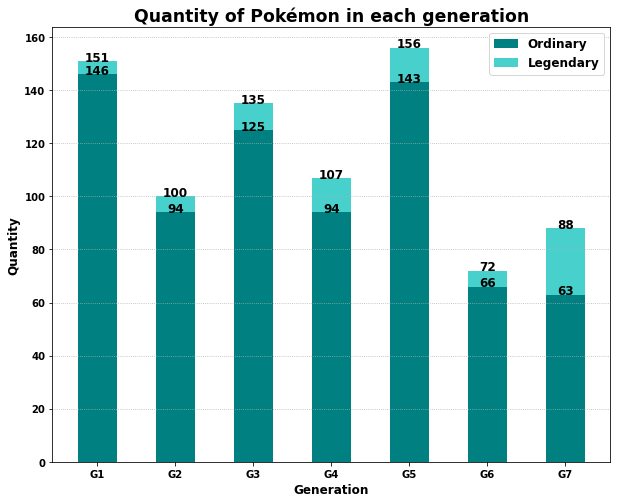

In [7]:
# give the width and colors of the bars
width = 0.5
colors = ['#008080', '#48D1CC']

# create a figure and set the size
fig, ax = plt.subplots(figsize=[10,8]) 

# plot the stacked bar chart
p1 = ax.bar(range(7), ordinary, width, color=colors[0])
p2 = ax.bar(range(7), legendary, width, bottom=ordinary, color=colors[1])

# other setting of the chart
ax.set_title('Quantity of Pokémon in each generation', fontsize='xx-large')
ax.set_xlabel('Generation', fontsize='large')
ax.set_ylabel('Quantity', fontsize='large')
ax.set_xticks(range(7))
ax.set_xticklabels(columns)
ax.legend((p1, p2), ('Ordinary', 'Legendary'), fontsize='large')
ax.grid(axis='y', ls=':')

# mark the numbers in the bar chart
for i in range(7):
    a = ordinary[i]
    b = total[i]
    ax.text(i, a, f'{a}', fontsize='large', horizontalalignment='center')
    ax.text(i, b, f'{b}', fontsize='large', horizontalalignment='center')

- We can find that the number of Pokémon doesn't have much to do with generation and so as two kinds of Pokémon. Generation 5 has the most and 6 has the least. In general, there is an upward trend in the proportion of 'legendary'.

<a id='2.2'></a>
### 2.2 Type

Although we can use the method in section 2.1 to process the type data and get the number of Pokémon with different types, there are two reasons against so. First, there are 18 types of Pokémon, which makes it hard to recognize the number of each type when the data is stacked in just one bar. Second, some Pokémons might have two types. The information in `'type2'` may be ignored when using the method above.Here we extract columns `'type1'` and `'type2'` from `data` to create `type_df` and try to find the number of Pokémon that correspond to all types of combinations.([*back to 3.1*](#3.1))

In [8]:
type_df = data.loc[:,['type1','type2']]

# For those single-type Pokémon, 'type2' is missing at first.
# So make them 'type2' == 'type1' to represent their types.

fill = type_df.loc[:,'type1']
type_df.loc[:,'type2'].fillna(fill, inplace = True)
type_df.T

,0,1,2,3,4,5,6,7,8,9,...,799,800,801,802,803,804,805,806,807,808
type1,grass,grass,grass,fire,fire,fire,water,water,water,bug,...,psychic,steel,fighting,poison,poison,rock,fire,electric,steel,steel
type2,poison,poison,poison,fire,fire,flying,water,water,water,bug,...,psychic,fairy,ghost,poison,dragon,steel,ghost,electric,steel,steel


<a id='2.2.1'></a>
Then we will check each Pokémon's type and calculate the number of each type or each dual type. Here we use the `type_list` we defined before just to name the `origin`'s index and colunms.
([*back to 1.2*](#1.2.1))

In [9]:
# create empty dataframe
data0 = np.zeros((18,18))
origin = pd.DataFrame(data=data0, index=type_list, 
                      columns=type_list, dtype='int32')

# get each Pokémon's type information
type1 = type_df.loc[:,'type1'].values
type2 = type_df.loc[:,'type2'].values

# fill in the information to the dataframe 
for i,j in zip(type1,type2):
    origin.loc[i,j] += 1

origin

,bug,dark,dragon,electric,fairy,fighting,fire,flying,ghost,grass,ground,ice,normal,poison,psychic,rock,steel,water
bug,18,0,0,4,2,3,2,13,1,6,1,0,0,11,0,3,5,3
dark,0,9,4,0,0,2,2,5,1,0,0,2,0,0,2,0,2,0
dragon,0,0,12,1,0,2,1,4,0,0,4,1,0,0,2,0,0,0
electric,0,0,0,28,2,0,0,3,1,0,0,0,2,0,0,0,4,0
fairy,0,0,0,0,16,0,0,2,0,0,0,0,0,0,0,0,0,0
fighting,0,1,0,0,0,22,0,1,1,0,0,1,0,0,2,0,1,0
fire,0,1,1,0,0,6,28,6,1,0,2,2,2,0,1,1,1,1
flying,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
ghost,0,1,1,0,1,0,3,2,9,5,2,0,0,3,0,0,0,0
grass,0,3,0,0,5,3,0,6,1,38,1,2,0,14,2,0,3,0


The data is not intuitive from the table, so we use heatmap to present the data. Using `imshow` is a way of drawing a heat map but kind of complicated. So `seaborn` is used to streamline the code cause it was developed based on the `matplotlib` and create visualizations with less code.

The number of single-type Pokémon is 395.
The proportion of single-type Pokémon is 48.83%


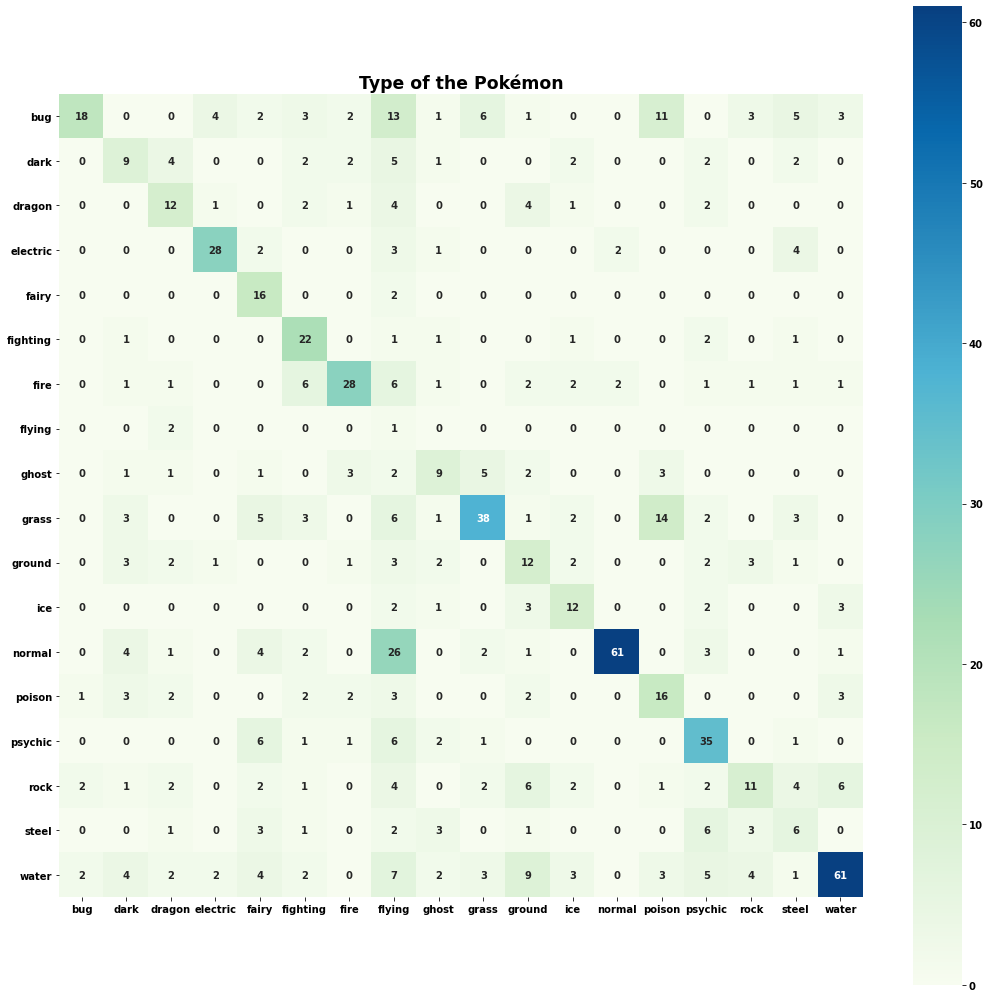

In [10]:
# ignore the FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# single type and dual type
single_type = (type_df.loc[:,'type1'] == type_df.loc[:,'type2']).sum()
total = origin.sum().sum()
print(f'The number of single-type Pokémon is {single_type}.')
print('The proportion of single-type Pokémon is {0:.2%}'.format(single_type/total))

# heatmap
fig,ax=plt.subplots(figsize=(18,18))
import seaborn as sns
sns.heatmap(origin,annot=True,cmap='GnBu',square=True)
ax.set_title('Type of the Pokémon', fontsize='xx-large');

- The vertical axis represents the primary type and the horizontal axis represents the secondary type.
- We can find that the squares on the diagonal are darker than the squares elsewhere generally, which indicates that Pokémons' types are concentrated in the single-type, while the distribution of the dual-type is relatively scattered. The proportion of single-type is 48.83% and the number of 'normal' and 'water' type is the most.
- Although there are many combinations of dual-type, the difference in quantity is still large.For example, the number of 'normal-flying' type is 26 while some other dual-types have nothing, which means that some types are hard to blend.

<a id='2.3'></a>
### 2.3 Base stats 

There are six base stats for each Pokémon that indicate its ability. Here we will give some general statistics of these value. The `stats_list` in [*section 1.2*](#1.2.1) will be used to extract the base stats from the `data`.([*back to 2.4*](#2.4))

In [11]:
stats_df = data.loc[:,['name']+stats_list].set_index('name')
stats_df.head()

,base_total,hp,attack,defense,sp_attack,sp_defense,speed
name,,,,,,,
Bulbasaur,318,45,49,49,65,65,45
Ivysaur,405,60,62,63,80,80,60
Venusaur,625,80,100,123,122,120,80
Charmander,309,39,52,43,60,50,65
Charmeleon,405,58,64,58,80,65,80


In [12]:
# statistic of base stats
stats_des = stats_df.describe()

# give a 'formater' to take two decimal places
formater = '{:.2f}'.format
stats_des.applymap(formater)

,base_total,hp,attack,defense,sp_attack,sp_defense,speed
count,809.00,809.00,809.00,809.00,809.00,809.00,809.00
mean,429.33,69.03,78.14,73.23,71.50,70.94,66.48
std,119.43,26.58,32.25,31.11,32.41,27.87,29.17
min,180.00,1.00,5.00,5.00,10.00,20.00,5.00
25%,323.00,50.00,55.00,50.00,46.00,50.00,45.00
50%,440.00,65.00,75.00,70.00,65.00,66.00,65.00
75%,509.00,80.00,100.00,90.00,92.00,90.00,87.00
max,780.00,255.00,185.00,230.00,194.00,230.00,180.00


> `stats_df` is a Dataframe of base stats.

> `stats_des` is some statistics on `stats_df`.

Then we will use a boxplot to present the data to get a general idea of the distribution of the base stats.

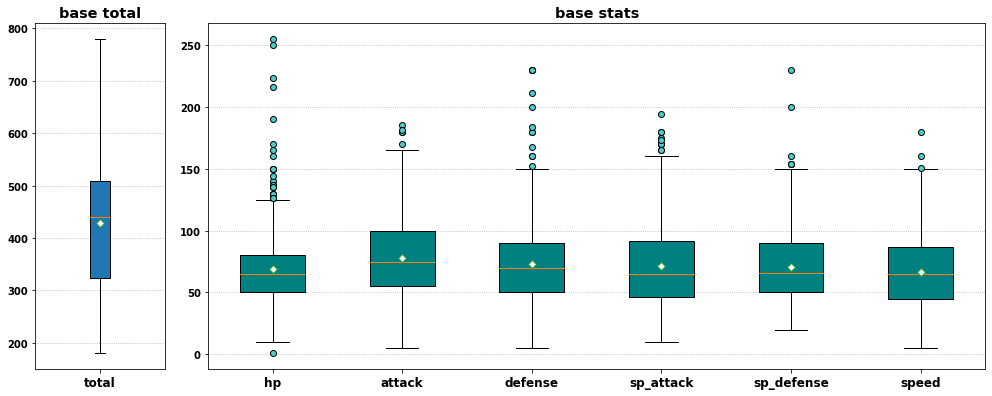

In [13]:
# some setting for boxplot
boxprops = {'facecolor':'#008080'}
flierprops = {'markerfacecolor':'#48D1CC'} 
medianprops = {'markerfacecolor':'orange'}
meanprops = {'marker':'D','markerfacecolor':'white'}

# ax0 for base total
ax0 = plt.axes([0.1, 0.1, 0.3, 1.2])
ax0.set_title('base total', fontsize='x-large')
ax0.set_xticklabels(['total'], fontsize='large')
ax0.grid(axis='y', ls=':')

ax0.boxplot(stats_df.loc[:, 'base_total'], patch_artist=True, 
            showmeans=True, flierprops=flierprops, 
            medianprops=medianprops, meanprops=meanprops)

# ax1 for six base stats
ax1 = plt.axes([0.5, 0.1, 1.8, 1.2])
ax1.set_title('base stats', fontsize='x-large')
ax1data = [stats_df.loc[:, i] for i in stats_list[1:]]
ax1.set_xticklabels(stats_list[1:], fontsize='large')
ax1.grid(axis='y', ls=':')

# patch_artist: fill the box with color ; showmeans: show the mean
# boxprops: box set; flierprops: extremum set; 
# medianprops: median set; meanprops: mean set
ax1.boxplot(ax1data, patch_artist=True, showmeans=True, 
            boxprops=boxprops, flierprops=flierprops, 
            medianprops=medianprops, meanprops=meanprops);

- As we can see in the dataframe and the boxplot, `base_total` varies widely between Pokémon ranging from 180 to 780.
- There is also a large deviation from the ability value of a single stats and extreme values occur more than comprehensive strength.
- Generally speaking, a Pokémon does not reach very high levels in all stats but in some particular ability, which means that it might have high `'attack'` but low `'defense'`. That's why single stats have so many extreme values. 
- Some Pokémon at an early stage may have lower abilities in all stats, while some legendary ones may be prominent in every stats. 

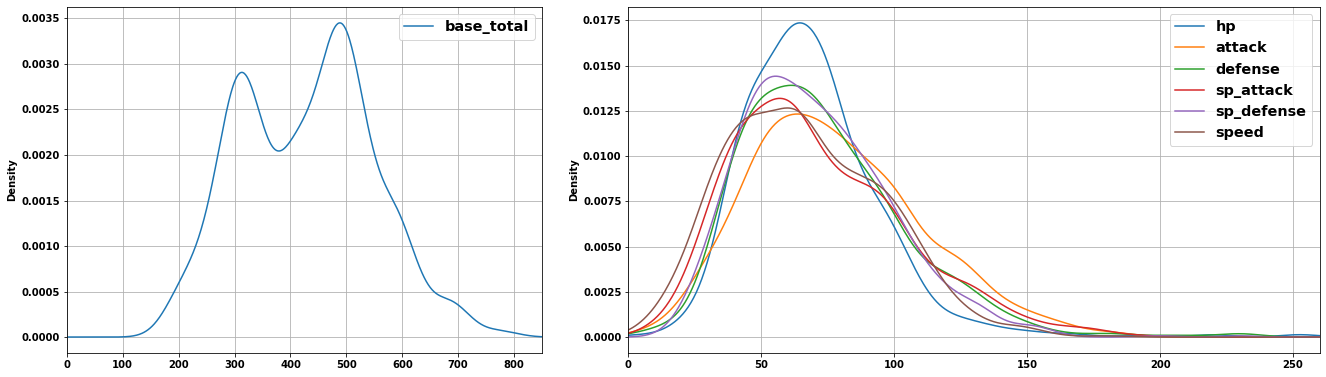

In [14]:
# kernel density of 'base_total'
ax0 = plt.axes([0.1, 0.1, 1.1, 1.2])
stats_df['base_total'].plot.density(xlim=(0, 850), label='base_total')
ax0.legend(fontsize='x-large')
ax0.grid()

# kernel density of six stats
ax1 = plt.axes([1.4, 0.1, 1.6, 1.2])
for i in stats_df.columns[1:]:
    stats_df[i].plot.density(xlim=(0, 260), label=i)
ax1.legend(fontsize='x-large')
ax1.grid();

- We can find that there are two peaks at nearly 300 and 500, which indicates that lower 'base_total' Pokémons are concentrated around 300, while higher are concentrated around 500.
- The six stats are all right-skewed, which indicates that the mean value is on the right side of mode, and the large extreme value is relatively more. The overall conclusion is consistent with the above.

<a id='2.4'></a>
### 2.4 Categorizations by base stats

Pokémon can be roughly divided into some categories due to their base stats (not an official rule). We only choose some Pokémon (`'base_total'` >= 75% quantile) for analysis because it will be intricate when you put more than 800 observations in a chart. In this section, we must use the `stats_df` and `stats_des` in [*section 2.3*](#2.3).

- `aggressive_index` = 0.6 * max{`'attack'`,`'sp_attack'`} + 0.4 * `'speed'`
- `tough_index` = 0.6 * max{`'defense'`,`'sp_defense'`} + 0.4 * `'hp'`
- If a Pokémon has higher `'aggressive_index'`, we will call it 'aggressive'.
- If a Pokémon has higher `'tough_index'`, we will call it 'tough'.
- If a Pokémon has exceptionally high `'aggressive_index'` or `'tough_index'`, we will call it 'special'.

In [15]:
def aggressive_index(s):  
    if s['attack'] > s['sp_attack']:
        aggressive_index = 0.6*s['attack'] + 0.4*s['speed']
    else:
        aggressive_index = 0.6*s['sp_attack'] + 0.4*s['speed']
    return aggressive_index

def tough_index(s):
    if s['defense'] > s['sp_defense']:
        tough_index = 0.6*s['defense'] + 0.4*s['hp']
    else:
        tough_index = 0.6*s['sp_defense'] + 0.4*s['hp']
    return tough_index

Use aggregate to apply on the functions defined above to combines multiple values into a single value and we will get a dataframe contained all Pokémons' `'aggressive_index'` and `'tough_index'`. Because the `.describe()` doesn't report the 'μ+3σ', so here we give the `a_special` and `t_special` as the critical value of 'special'.

In [16]:
# compute the two index
# stats_df is from section 2.3
index = stats_df.agg((aggressive_index, tough_index), axis=1)

# μ+3σ 'special' critical value
a_special = index['aggressive_index'].mean() + 3*index['aggressive_index'].std()
t_special = index['tough_index'].mean() + 3*index['tough_index'].std()

index.describe()

,aggressive_index,tough_index
count,809.000000,809.000000
mean,79.812608,76.090729
std,26.664726,24.544133
min,8.000000,27.400000
25%,59.800000,57.200000
50%,78.000000,74.800000
75%,97.600000,92.000000
max,172.400000,183.000000


In [17]:
# choose the Pokémon which 'base_total' >= 75% quantile and get their index
# stats_df and stats_des is from section 2.3
stats_high = stats_df.loc[stats_df['base_total'] >= stats_des.loc['75%','base_total']]
index_high = stats_high.agg((aggressive_index, tough_index), axis=1)

> `stats_high` is a sample of `stats_df`.

> `index_high` is a sample of `index`.

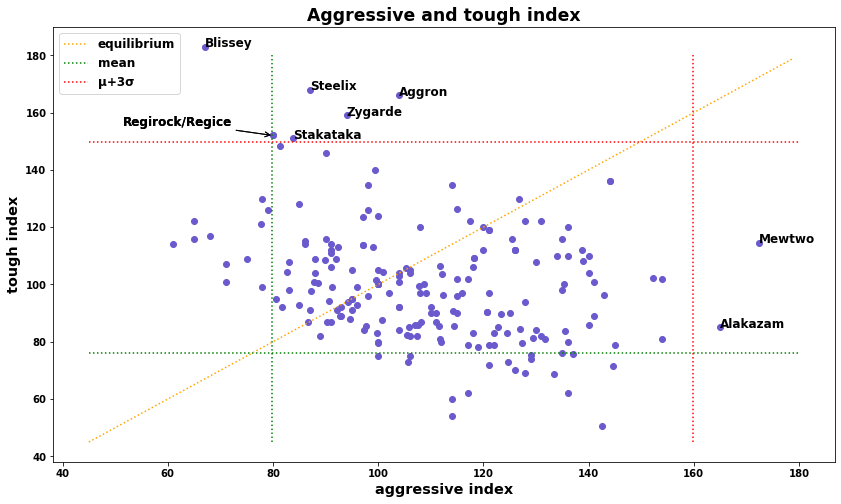

In [18]:
fig, ax = plt.subplots(figsize=(14,8))

# scatter plot
ax.scatter(index_high['aggressive_index'], 
           index_high['tough_index'], color='#6A5ACD')

# 'aggressive_index' == 'tough_index'
ax.plot(range(45,180),range(45,180), 
        color="orange", linestyle=':', label='equilibrium')

# indicate the mean and special critical value
ax.vlines(index['aggressive_index'].mean(), 45, 180, 
          color="green", linestyle=':')
ax.hlines(index['tough_index'].mean(), 45, 180, 
          color="green", linestyle=':', label='mean')
ax.vlines(a_special, 45, 180, color="red", linestyle=':')
ax.hlines(t_special, 45, 180, color="red", linestyle=':', label='μ+3σ')

# other settings
ax.set_xlabel('aggressive index', fontsize='x-large')
ax.set_ylabel('tough index', fontsize='x-large')
ax.set_title('Aggressive and tough index', fontsize='xx-large')
ax.legend(fontsize='large')

# mark the special Pokémons
for i in index_high.index:
    a = index_high.loc[i,'aggressive_index']
    t = index_high.loc[i,'tough_index']
    
    # This is separate for fear of overlapping the text of the annotations.
    if (i == 'Regirock')|(i == 'Regice'):
        ax.annotate('Regirock/Regice',(a,t), xytext=(-150, 10), 
                    textcoords="offset points", fontsize='large',
                    arrowprops=dict(arrowstyle="->"))
        
    elif (a > a_special)|(t > t_special):
        ax.text(a, t, i, fontsize='large') 

- In our selected part of the Pokémons, most of them fall in the space enclosed by the green and red lines in the figure. That means if a Pokémon possesses higher `'base_total'` (>= 75% quantile), it will more chance to have higher index in two aspects (>= mean).
- Relatively speaking, the dots above the dotted yellow line indicate that the Pokemon is 'tough', and those below the dotted yellow line indicate that the Pokemon is 'aggressive'. So the 'aggressive' Pokemons in the sample are in the majority.
- There are nine dots that fall outside the dotted red line, which means that they are 'special' in specific stats.But we can't see in this figure about how their six specific stats are distributed, so we have to conduct further data analysis in section 2.5.

<a id='2.5'></a>
### 2.5 Stats radar map

This section will select the nine 'special' Pokémons' information as a sample `special_data`. Create another two dataframes `all_data` (all Pokémons) and `high_data` (25% Pokémons) in the same way.

In [19]:
# get those special Pokémon's base stats and index
a = index_high.loc[:,'aggressive_index']
t = index_high.loc[:,'tough_index']
stats_special = stats_high.loc[(a > a_special)|(t > t_special)]
index_special = index_high.loc[(a > a_special)|(t > t_special)]

# create three dataframe
special_data = pd.merge(stats_special, index_special, 
                        left_on='name', right_index=True)
all_data = pd.merge(stats_df, index, 
                        left_on='name', right_index=True)
high_data = pd.merge(stats_high, index_high, 
                        left_on='name', right_index=True)

special_data

,base_total,hp,attack,defense,sp_attack,sp_defense,speed,aggressive_index,tough_index
name,,,,,,,,,
Alakazam,600,55,50,65,175,105,150,165.0,85.0
Mewtwo,780,106,150,70,194,120,140,172.4,114.4
Steelix,610,75,125,230,55,95,30,87.0,168.0
Blissey,540,255,10,10,75,135,55,67.0,183.0
Aggron,630,70,140,230,60,80,50,104.0,166.0
Regirock,580,80,100,200,50,100,50,80.0,152.0
Regice,580,80,50,100,100,200,50,80.0,152.0
Zygarde,708,216,100,121,91,95,85,94.0,159.0
Stakataka,570,61,131,211,53,101,13,83.8,151.0


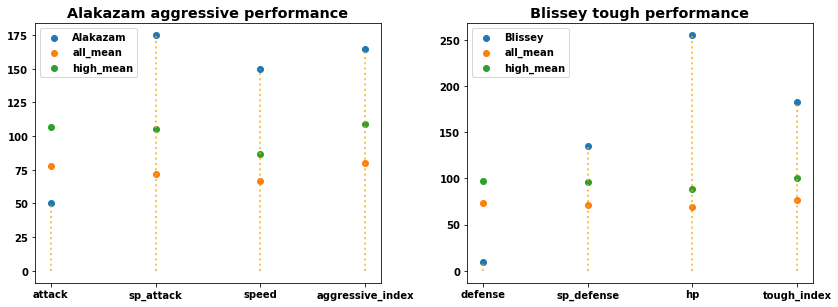

In [20]:
# 'aggresive'
# basic settings
ax0 = plt.axes([0.1, 0.1, 0.8, 0.9])
ax0.set_title('Alakazam aggressive performance', fontsize = 'x-large')

# get the specific value of the Pokémon
a_ = ['attack', 'sp_attack', 'speed', 'aggressive_index']
aggressive = special_data.loc['Alakazam'][a_]

# find the criteria for comparison
aggressive_all_mean = all_data.mean()[a_]
aggressive_high_mean = high_data.mean()[a_]

# scatter plot 
ax0.scatter(np.array(a_), aggressive, label='Alakazam')
ax0.scatter(np.array(a_), aggressive_all_mean, label='all_mean')
ax0.scatter(np.array(a_), aggressive_high_mean, label='high_mean')

# give some tag lines and legend
ax0.vlines(np.array(a_), ymin=0, ymax=aggressive, color='orange', 
           alpha=0.7, linewidth=2, linestyle=':')
ax0.legend(fontsize = 'medium')

# 'tough'
# nearly the same as above
ax1 = plt.axes([1.1, 0.1, 0.8, 0.9])
ax1.set_title('Blissey tough performance', fontsize = 'x-large')

t_ = ['defense', 'sp_defense', 'hp', 'tough_index']
tough = special_data.loc['Blissey'][t_]

tough_mean_all = all_data.mean()[t_]
tough_mean_high = high_data.mean()[t_]

ax1.scatter(np.array(t_), tough, label='Blissey')
ax1.scatter(np.array(t_), tough_mean_all, label='all_mean')
ax1.scatter(np.array(t_), tough_mean_high, label='high_mean')

ax1.vlines(np.array(t_), ymin=0, ymax=tough, color='orange', 
           alpha=0.7, linewidth=2, linestyle=':')
ax1.legend(fontsize = 'medium', loc='upper left');

- From the data, it can be seen that some Pokémons are 'aggressive' due to the advantage of `'sp_attack'` and `'speed'`, but they are relatively mediocre in `'attack'`, such as Alakazam. Some Pokémons are 'tough' because of their superior `'hp'` but are less able to resist attacks, such as Blissey.

Therefore, the simple categorization of 'aggressive' and 'tough' is a bit too arbitrary, and a more detailed categorization is needed obviously. Here we will plot the six stats on a radar map to visually see where a Pokémon stands out. To prevent label overlapping, here we change the `'sp_attack'` and `'sp_defense'` into `'sp_a'` and `'sp_d'`.

In [21]:
# remove the 'base_total'
df0 = stats_special[stats_special.columns[1:]]
df0 = df0.rename(columns={'sp_attack':'sp_a', 'sp_defense':'sp_d'})
df0  # what we will input into the following function 

,hp,attack,defense,sp_a,sp_d,speed
name,,,,,,
Alakazam,55,50,65,175,105,150
Mewtwo,106,150,70,194,120,140
Steelix,75,125,230,55,95,30
Blissey,255,10,10,75,135,55
Aggron,70,140,230,60,80,50
Regirock,80,100,200,50,100,50
Regice,80,50,100,100,200,50
Zygarde,216,100,121,91,95,85
Stakataka,61,131,211,53,101,13


In [22]:
# get the boundary value of the map
def boundary(df):
    minb = maxb = 0
    a,b = df.values.shape
    for i in range(a):
        for j in range(b):
            value = df.iloc[i,j]
            if  value < minb:
                minb = value
            if value > maxb:
                maxb = value
    return minb, maxb

import matplotlib.colors as mcolors

# create radar map 
def base_stats_map(df, rows, columns):
    """
    create several radar map on base stats
    inputs:
        df: a dataframe contain six stats of Pokémons
            the index must be Pokémons' names
            the columns must be stats names
        rows: the number of rows on the figure
        columns: the number of columns on the figure
    outputs:
        (rows*columns) radar maps in one figure
    """
    # get all available colors
    colors = list(mcolors.TABLEAU_COLORS)
    
    minb, maxb = boundary(df)
    number = len(df.columns)
    
    # divide the circle into sections based on the number of stats
    # 0 to 2pi, divide for several times
    angles = np.linspace(0, 2*np.pi, number, endpoint=False)
    # go around the circle and come back to the origin
    angles = np.append(angles, angles[0])
    
    # create polar axises of rows * columns
    fig, ax = plt.subplots(rows, columns, figsize=(18,18), 
                           subplot_kw=dict(polar=True))
    
    # The original ax.shape is a two-dimensional array.
    # For the convenience of the next iteration loop, 
    # we break it down into a one-dimensional array.
    ax = ax.ravel()
    
    name = df.index
    stats = df.values
    
    for i, (name, stats) in enumerate(zip(name, stats)):
        # go around the circle and come back to the origin
        stats = np.append(np.array(stats), stats[0])
        
        # plot on each axis and fill color
        ax[i].plot(angles, stats, color=colors[i])
        ax[i].fill(angles, stats, alpha=0.7, color=colors[i])
        
        # set the labels of xtick
        ax[i].set_xticks(angles)
        ax[i].set_xticklabels(df.columns)
        
        # set the title (or the 'name')
        ax[i].set_title(name, size=10, color='black', position=(0.5, 0.4))
                
        # set the minimun and maximun r
        # +0.1 to prevent the outermost circle from appearing incompletely
        ax[i].set_rmin(minb)
        ax[i].set_rmax(maxb + 0.1)
    plt.show()

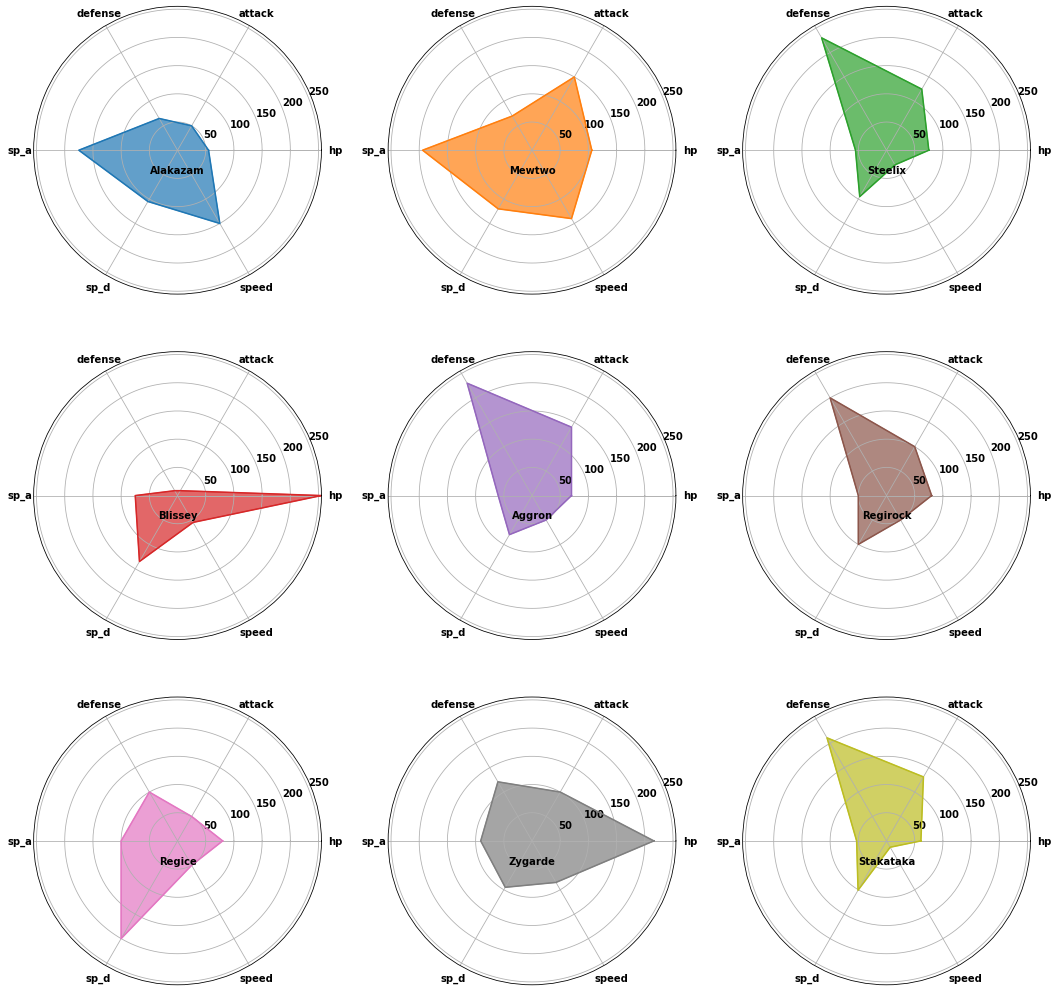

In [23]:
# plot the radar map
base_stats_map(df0,3,3)

- We can see the advantages and disadvantages of each Pokémon from the radar map clearly. Since the unit lengths in different radar maps are the same, direct comparisons can be made between them. For example, Mewtwo has the highest `'sp_attack'` ,Aggron has the highest `'defense'`...
- The area of the shaded area can be roughly seen as the `'base_total"` of Pokémon, with the larger the area, the stronger the overall strength.
- This method can be applied on every Pokémon to describe their specific abilities.

<a id='3.0'></a>
## 3. Battle simulation

<a id='3.1'></a>
### 3.1 Battle mechanism

The `data_battle` we will use here is the copy of `data` with some same treatment as [*section 2.2*](#2.2) (fill in the `NaN` in `'type2'`). In this section, we will create a specific battle mechanism to simulate the battle between the Pokémons.

In [24]:
fill = data.loc[:,'type1']
data_battle = data.copy()
data_battle.loc[:,'type2'].fillna(fill, inplace=True)

Here are the details:
- We will select two Pokémons randomly and make them fight assuming that the odds of any two Pokémons fighting are the same, and that the result of the battle is determined only by their types and base stats. We stipulate that the same Pokémons will never be in one battle.
- Firstly, decide which Pokémons is the first to attack based on which has higher `'speed'`. The faster one is `'first'`, the slower one is `'second'`.
- Secondly, compute how much damage they can do to their opponents.
 - `'dm'`: Damage multiplier. As we see in the [*section 1.2*](#1.2), each Pokémon has 18 performances against other types, which means that when others attack this Pokémon, the damage is determined by the number of the corresponding type. For example, the `'dm'` of a single-type (grass) Pokémon to a dual-type (green-bug) is 0.25; the `'dm'` of a dual-type (green-bug) Pokémon to a single-type (grass) is 0.5 * 2 = 1. (See the code below)
 - `'da'`: Damage. Assume that when a Pokémon has higher `'attack'` than `'sp_attack'`, it will use physical attacks and its opponent will resist the `'attack'` with `'defense'`. If one's `'attack'` is lower than the other's `'defense'`, the attack will give a `'da'` = 0.5 * `'dm'`.If not, the `'da'` = (one's `'attack'` - the other's `'defense'`) * `'dm'`. Same thing for those who have a higher `'sp_attack'`.
- Lastly, when attacked, a Pokémon will lose some `'hp'` (Δhp = -`'da'`). When one of two runs out of its `'hp'`, the battle is over and the round of the battle will be recorded. 

In [25]:
def choose_who(df1):
    a, b = np.random.randint(0,809,(2,))
    # not the same
    if a == b:
        if a == 0:
            a = a + 1
        else:
            a = a - 1
    p1 = df1.iloc[a]
    p2 = df1.iloc[b]
    
    # return all the information of the two Pokémons
    return p1, p2


def who_first(p1, p2):
    # based on their 'speed'
    if p1['speed'] >= p2['speed']:
        return p1, p2
    else:
        return p2, p1


def damage_multiplier(p1, p2):
    p1type1 = p1['type1']
    p1type2 = p1['type2']
    p2type1 = p2['type1']
    p2type2 = p2['type2']
    if p1type1 == p1type2:
        dm1 = p2[p1type1]
    else:
        dm1 = p2[p1type1] * p2[p1type2] 
    if p2type1 == p2type2:
        dm2 = p1[p2type1]
    else:
        dm2 = p1[p2type1] * p1[p2type2]
        
    # the battle must end
    # so dm1 = dm2 = 0 is not allowed
    if (dm1 == 0) & (dm2 == 0):
        dm1, dm2 = (0.05, 0.05)
    return dm1, dm2


def damage(p1, p2, dm1, dm2):
    if p1['attack'] >= p1['sp_attack']:
        if p1['attack'] <= p2['defense']:
            # negative damage is not allowed
            da1 = 0.5 * dm1
        else:
            da1 = (p1['attack']-p2['defense']) * dm1
    else:
        if p1['sp_attack'] <= p2['sp_defense']:
            da1 = 0.5 * dm1
        else:
            da1 = (p1['sp_attack']-p2['sp_defense']) * dm1
            
    # same as above
    if p2['attack'] >= p2['sp_attack']:
        if p2['attack'] <= p1['defense']:
            da2 = 0.5 * dm2
        else:
            da2 = (p2['attack']-p1['defense']) * dm2
    else:
        if p2['sp_attack'] <= p1['sp_defense']:
            da2 = 0.5 * dm2
        else:
            da2 = (p2['sp_attack']-p1['sp_defense']) * dm2
    return da1, da2


def bout(p1, p2, da1, da2):
    bround = 0
    hp1 = p1['hp']
    hp2 = p2['hp']
    while (hp1 > 0) & (hp2 > 0):
        # the while loop adds 1, the round adds 1
        bround += 1
        
        if da1 >= hp2:
            hp2 = 0
            winner = p1['name']
            loser = p2['name']
            break # when one's 'hp'=0, battle over
        hp2 = hp2 - da1    
        if da2 >= hp1:
            hp1 = 0
            winner = p2['name']
            loser = p1['name']
            break
        hp1 = hp1 - da2
    return (winner, round(hp1,2), 
            round(hp2,2), bround)
    
    
def battle(df, N):
    """
    get a df of all information of some Pokémons
    and simulate battles for N times to get the results
    return another dataframe
    """
    # make a list to store the results
    list0 = [0]
    
    # simulate for N times
    for i in range(N):
        # firstly
        p1, p2 = choose_who(df)
        first, second = who_first(p1, p2)
        
        # secondly
        dm1, dm2 = damage_multiplier(first, second)
        da1, da2 = damage(first, second, dm1, dm2)
        
        # lastly
        winner, hp1, hp2, bround = bout(first, second, da1, da2)
        
        # add one result after one battle ends
        list0.append([first['name'], second['name'], winner, 
                      bround, first['hp'], second['hp'], 
                      hp1, hp2, dm1, dm2, da1, da2])
    
    # change the results into a dataframe
    columns=['first', 'second', 'winner', 'round', 
             'first_hp0', 'second_hp0', 'first_hp', 'second_hp', 
             'first_dm', 'second_dm', 'first_da', 'second_da']
    df0 = pd.DataFrame(data=list0[1:], index=range(N), 
                       columns=columns)
    
    return df0

In [26]:
%%timeit
simulation_sample = battle(data_battle, 50)

60.8 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Simulating for 50 times needs 60-80ms, which is not very quickly. However, less simulations can not produce reliable results. So saving the CSV document with large amounts of data (simulating for 100,000 times) is not demonstrated here. (The code will showed as markdown)
```python
simulation_of_battle = battle(data_battle, 100000)
simulation_of_battle.to_csv('simulation_of_battle.csv')
```

<a id='3.2'></a>
### 3.2 Battle result

In [27]:
simulation_of_battle = pd.read_csv('simulation_of_battle.csv')
simulation_of_battle

,Unnamed: 0,first,second,winner,round,first_hp0,second_hp0,first_hp,second_hp,first_dm,second_dm,first_da,second_da
0,0,Skiploom,Starly,Skiploom,6,55,40,5.00,0.00,0.50,2.00,7.500,10.00
1,1,Hoopa,Timburr,Hoopa,1,80,75,80.00,0.00,2.00,0.00,270.000,0.00
2,2,Lopunny,Banette,Banette,19,65,64,0.00,6.05,0.05,0.05,3.050,3.55
3,3,Vivillon,Guzzlord,Guzzlord,2,80,223,0.00,75.00,2.00,1.00,74.000,51.00
4,4,Eevee,Aromatisse,Aromatisse,2,55,101,0.00,100.00,1.00,1.00,0.500,34.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,Pidgeotto,Gourgeist,Gourgeist,28,63,85,0.00,84.30,0.05,0.05,0.025,2.25
99996,99996,Luvdisc,Hippopotas,Hippopotas,3,43,68,0.00,65.00,2.00,1.00,1.000,17.00
99997,99997,Shaymin,Wimpod,Shaymin,1,100,25,100.00,0.00,1.00,1.00,90.000,0.50
99998,99998,Doduo,Slurpuff,Slurpuff,1,35,82,0.00,81.50,1.00,1.00,0.500,50.00


In [28]:
# Calculate how many times each Pokémon appears in the battle simulations
first_one = simulation_of_battle['first'].value_counts()
second_one = simulation_of_battle['second'].value_counts()
occur = first_one + second_one 
occur.isnull().sum()

9

In [29]:
# compute the win rate of each Pokémon
winner = simulation_of_battle['winner'].value_counts()
rate = winner/occur
# regardless of the NaN in win rate
# here is the top 10 of win rate
rate.sort_values().tail(21)[:10][::-1]

Kyogre        0.995261
Tyranitar     0.991189
Regigigas     0.981900
Gyarados      0.972868
Slaking       0.961977
Darmanitan    0.959184
Scizor        0.958159
Wishiwashi    0.947368
Aggron        0.945946
Blastoise     0.940945
dtype: float64

- Although we have simulate for 100,000 times, there are still 9 Pokémons did not appear.
- The simulation results can be visualized by the method used in the second 2, which will not be repeated here.
- The simulation results can be further analyzed and extended by machine learning.

<a id='4.0'></a>
## 4. The last

Although the dataset used here is not academic in some ways. But the operation of data visualization can be applied to many other datasets. Although I chose such a dataset with a playful attitude at the beginning, after a period of practical operation, I found that I could also learn a lot of data processing knowledge from it, which benefited me a lot.